# Relax Inc.  Take Home Assignment

The  data is available as two attached CSV  files:
 -  'takehome_user_engagement.csv'
 -  'takehome_users.csv'

 The data has the following two tables:",
    1. A user table ("takehome_users.csv") with data on 12,000 users who signed up for the product in the last two years. This table includes:,
       - name: the user's name
       - object_id: the user's id
       - email: email address
       - creation_source: how their account was created.
           This takes on one of 5 values:
            - PERSONAL_PROJECTS: invited to join another user's personal workspace
            - GUEST_INVITE: invited to an organization as a guest (limited permissions)
            - ORG_INVITE: invited to an organization (as a full member)
            - SIGNUP: signed up via the website
            - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
       - creation_time: when they created their account
       - last_session_creation_time: unix timestamp of last login
       - opted_in_to_mailing_list: whether they have opted into receiving marketing emails
       - enabled_for_marketing_drip: whether they are on the regular marketing email drip
       - org_id: the organization (group of users) they belong to
       - invited_by_user_id: which user invited them to join (if applicable)
       
   2. A usage summary table ("takehome_user_engagement.csv") that has a row for each day that a user logged into the product.
      Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period.
   3. Business problem: to identify which factors predict future user adoption.

### Load Libraries and Data

In [27]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv')

In [4]:
#view the users dataset
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users.index

RangeIndex(start=0, stop=12000, step=1)

In [6]:
#Get a summary of the users dataset and see if there is any NA values
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [7]:
#view the engegement dataset
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
#Get a summary of the engagement dataset and check data types
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [9]:
# get statistic summary
engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [10]:
# Check for missing values in each dataset
print('takehome_users dataset : missing {}'.format(users.isnull().any()))
print('takehome_users_engagement dataset : missing {}'.format(engagement.isnull().any()))

takehome_users dataset : missing object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool
takehome_users_engagement dataset : missing time_stamp    False
user_id       False
visited       False
dtype: bool


In [11]:
# 'last_session_creation_time' and 'i'nvited_by_user_id' have missing values 

In [12]:
#convert to datetime data type
users.creation_time = pd.to_datetime(users.creation_time)

In [13]:
# rename object_id to user_id for consistency
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [14]:
#convert timestamp to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [15]:
# set time_stamp as index
#engagement = engagement.set_index('time_stamp')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [16]:
groups = engagement.groupby('user_id')

In [17]:
[x for x in groups]

[(1,
             time_stamp  user_id  visited
  0 2014-04-22 03:53:30        1        1),
 (2,
              time_stamp  user_id  visited
  1  2013-11-15 03:45:04        2        1
  2  2013-11-29 03:45:04        2        1
  3  2013-12-09 03:45:04        2        1
  4  2013-12-25 03:45:04        2        1
  5  2013-12-31 03:45:04        2        1
  6  2014-01-08 03:45:04        2        1
  7  2014-02-03 03:45:04        2        1
  8  2014-02-08 03:45:04        2        1
  9  2014-02-09 03:45:04        2        1
  10 2014-02-13 03:45:04        2        1
  11 2014-02-16 03:45:04        2        1
  12 2014-03-09 03:45:04        2        1
  13 2014-03-13 03:45:04        2        1
  14 2014-03-31 03:45:04        2        1),
 (3,
              time_stamp  user_id  visited
  15 2013-03-19 23:14:52        3        1),
 (4,
              time_stamp  user_id  visited
  16 2013-05-22 08:09:28        4        1),
 (5,
              time_stamp  user_id  visited
  17 2013-01-22 10:14:2

### Identify ' adopted user'

In [18]:
#Generate a dictionary that classifies adopted user versus non-adopted users
adopted_dict = {}

for group in engagement.groupby('user_id'):
    user_id = group[0]
    login_counts = len(group[1])
    user_logins = group[1]['time_stamp'].sort_values().reset_index(drop=True)
    
    #Check if number of logins is greater than 3, if so continue checking the status
    if login_counts >= 3:
        num = 0
        for i, time in enumerate(user_logins):
            if i < len(user_logins)-2:
                start = time
                end = start + pd.Timedelta('7D')
                next1 = user_logins[i+1]
                next2 = user_logins[i+2]
                if (next1 < end) & (next2<end):
                    num += 1
        if num == 0:
            adopted_dict[user_id] = 0
        else:
            adopted_dict[user_id] = 1
    else:
        adopted_dict[user_id] = 0

In [19]:
#Count the total number of adopted users
count = 0
for key, value in adopted_dict.items():
    if value == True:
        count +=1
print ('There is {} adopted users in this dataset.'.format(count))

There is 1602 adopted users in this dataset.


In [20]:
adopted_dict

{1: 0,
 2: 1,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 10: 1,
 11: 0,
 13: 0,
 14: 0,
 17: 0,
 19: 0,
 20: 1,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 33: 1,
 36: 0,
 37: 0,
 41: 0,
 42: 1,
 43: 1,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 1,
 51: 0,
 53: 1,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 63: 1,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 1,
 72: 0,
 73: 0,
 74: 1,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 80: 1,
 81: 1,
 82: 1,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 1,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 103: 0,
 105: 0,
 106: 0,
 107: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 119: 0,
 121: 0,
 123: 0,
 124: 0,
 125: 0,
 126: 0,
 127: 0,
 128: 0,
 132: 0,
 133: 1,
 135: 1,
 136: 0,
 138: 0,
 139: 0,
 140: 0,
 141: 1,
 142: 0,
 143: 0,
 144: 0,
 146: 1,
 147: 0,
 150: 0,
 151: 0,
 153: 1,
 154: 0,
 155: 0

In [21]:
# Merge adopted user status for each user id into the users dataset
users['adopted_user'] = users['user_id'].map(adopted_dict)

In [22]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


### Cleaning Data

In [56]:
#extracting email domain from the email list
users['email_domain'] = users['email'].apply(lambda x: x.split('@')[1].split('.')[0])

In [58]:
print ('There are {} email domains in this dataset.'.format(users_new['email_domain'].nunique()))

There are 1184 email domains in this dataset.


In [24]:
#Converting to creation time and last login time to datetime type
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])

#calculate days since signup
users['days_since_signup'] = (users['last_session_creation_time'] - users['creation_time']).apply(lambda x: x.days)

In [25]:
#Extract all columns into a new dataframe except: object_id, creation_time, name, email, last_session_creation_time
users_new = users[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
                  'org_id', 'invited_by_user_id', 'adopted_user', 'email_domain', 'days_since_signup']]
users_new.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,days_since_signup
0,GUEST_INVITE,1,0,11,10803.0,0.0,yahoo,0.0
1,ORG_INVITE,0,0,1,316.0,1.0,gustr,136.0
2,ORG_INVITE,0,0,94,1525.0,0.0,gustr,0.0
3,GUEST_INVITE,0,0,1,5151.0,0.0,yahoo,1.0
4,GUEST_INVITE,0,0,193,5240.0,0.0,yahoo,5.0


In [26]:
users_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  int64  
 4   invited_by_user_id          6417 non-null   float64
 5   adopted_user                8823 non-null   float64
 6   email_domain                12000 non-null  object 
 7   days_since_signup           8823 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 750.1+ KB


### Data Visualization

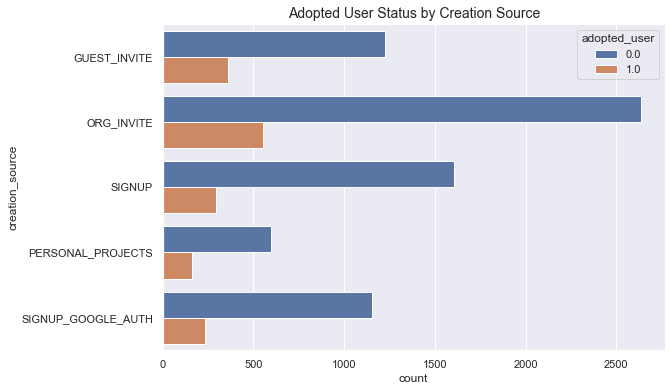

In [54]:
# 'creation_source'
# sns.set(style="darkgrid")
plt.figure(figsize=(9,6))
sns.countplot(y='creation_source', data=users_new, hue='adopted_user')
plt.title('Adopted User Status by Creation Source', fontsize=14);

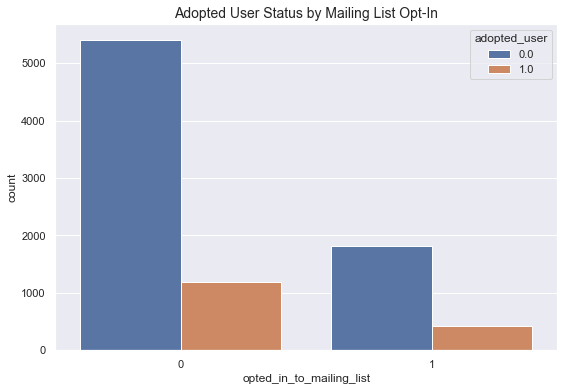

In [46]:
# visualize 'opted_in_to_mailing_list'
plt.figure(figsize=(9,6))
sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user', data=users_new)
plt.title('Adopted User Status by Mailing List Opt-In', fontsize=14);

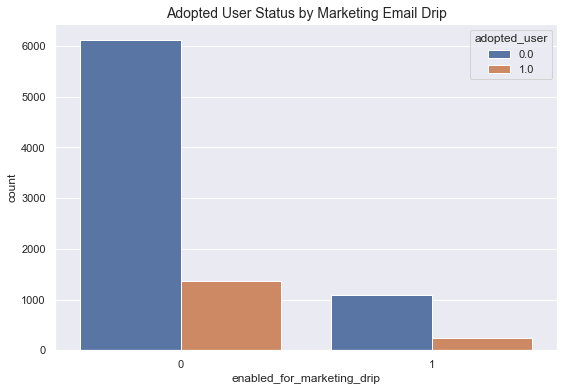

In [48]:
# 'enabled_for_marketing_drip'
plt.figure(figsize=(9,6))
sns.countplot(x='enabled_for_marketing_drip', hue='adopted_user',data=users_new)
plt.title('Adopted User Status by Marketing Email Drip', fontsize=14);

In [ ]:
plt.subplots(figsize=(10, 5))
sns.boxplot(x='Education', y='Income', hue='AcceptedCmp6', data=df)
plt.xticks(rotation='vertical')
plt.xlabel('Education')
plt.ylabel('Income')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.1,1))
plt.show();

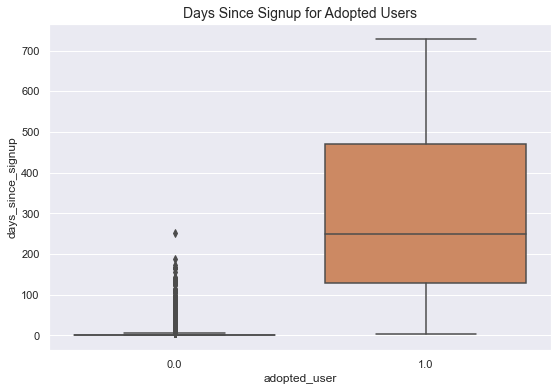

In [50]:
# 'days_since_signup'
plt.figure(figsize=(9,6))
sns.boxplot(y='days_since_signup', x='adopted_user', data=users_new)
plt.title('Days Since Signup for Adopted Users', fontsize=14);

In [59]:
#Since there are several email domains, will only loook at the top 10 and selectively choose the important ones
users_new.email_domain.value_counts().head(10)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
rerwl            2
oqpze            2
qgjbc            2
dqwln            2
Name: email_domain, dtype: int64

In [60]:
#Create main email domains based on counts
main_domain = ['gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail']

In [61]:
#Generate "others" category for the email domain
users_new['email_domain'][~users_new['email_domain'].isin(main_domain)] = 'others'

In [62]:
users_new.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,days_since_signup
0,GUEST_INVITE,1,0,11,10803.0,0.0,yahoo,0.0
1,ORG_INVITE,0,0,1,316.0,1.0,gustr,136.0
2,ORG_INVITE,0,0,94,1525.0,0.0,gustr,0.0
3,GUEST_INVITE,0,0,1,5151.0,0.0,yahoo,1.0
4,GUEST_INVITE,0,0,193,5240.0,0.0,yahoo,5.0


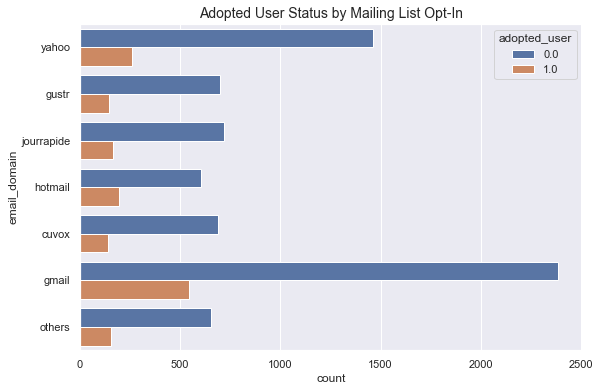

In [63]:
# visualize 'opted_in_to_mailing_list'
plt.figure(figsize=(9,6))
sns.countplot(y='email_domain', hue='adopted_user', data=users_new)
plt.title('Adopted User Status by Email Domain', fontsize=14);

### Data Preprocessing

#### Encoding categorical features

In [65]:
# 'creation_source' and 'email_domain'
users_encoded = pd.get_dummies(users_new, columns=['creation_source', 'email_domain'])

In [73]:
users_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            12000 non-null  int64  
 1   enabled_for_marketing_drip          12000 non-null  int64  
 2   org_id                              12000 non-null  int64  
 3   invited_by_user_id                  6417 non-null   float64
 4   adopted_user                        8823 non-null   float64
 5   days_since_signup                   8823 non-null   float64
 6   creation_source_GUEST_INVITE        12000 non-null  uint8  
 7   creation_source_ORG_INVITE          12000 non-null  uint8  
 8   creation_source_PERSONAL_PROJECTS   12000 non-null  uint8  
 9   creation_source_SIGNUP              12000 non-null  uint8  
 10  creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8  
 11  email_domain_cuvox                  12000

In [74]:
# drop null values
users_encoded = users_encoded.dropna()

In [106]:
users_encoded.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,days_since_signup,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain_cuvox,email_domain_gmail,email_domain_gustr,email_domain_hotmail,email_domain_jourrapide,email_domain_others,email_domain_yahoo
0,1,0,11,10803.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,316.0,1.0,136.0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,94,1525.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,1,5151.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,193,5240.0,0.0,5.0,1,0,0,0,0,0,0,0,0,0,0,1


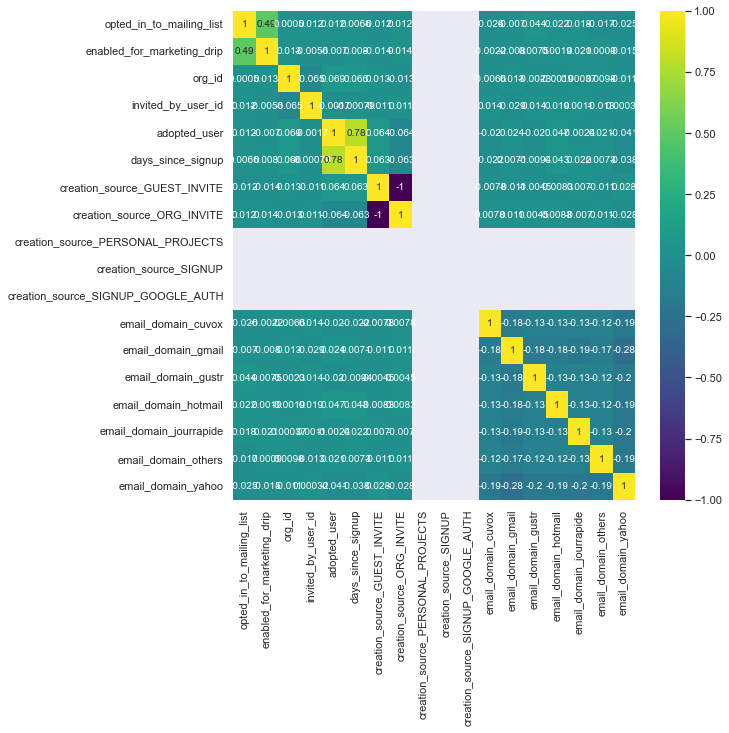

In [80]:
corr = users_encoded.corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr, annot=True,cmap="viridis");

In [79]:
c = corr.abs().unstack().drop_duplicates().reset_index()
c = c.rename(columns={'level_0': 'feature 1', 'level_1': 'feature 2', 0: 'Correlation'})
c = c.query('.3 <= Correlation < 1').sort_values(by = 'Correlation', ascending = False).reset_index(drop=True)
c.style.background_gradient(cmap='Set1_r')

,feature 1,feature 2,Correlation
0,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,1.000000
1,adopted_user,days_since_signup,0.782294
2,opted_in_to_mailing_list,enabled_for_marketing_drip,0.493088


#### Train/Test Split

In [81]:
#Split dataset into target and features
X = users_encoded.drop('adopted_user', axis=1)
y = users_encoded['adopted_user']

In [82]:
#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [92]:
# for a binary problem ==> Logistic Regression is used
lr = LogisticRegression()

#Build grid cearch for hyperparameter optimization
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.001, 0.01, 0.1], 
             'tol':[1e-5, 1e-4, 1e-3]}

clf = GridSearchCV(lr, parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1],
                         'tol': [1e-05, 0.0001, 0.001]},
             scoring='roc_auc')

In [93]:
clf.best_params_

{'C': 0.001, 'tol': 1e-05}

In [94]:
#Training the Logistic Regression Model with the best parameters
lr = LogisticRegression(C=0.01, tol=1e-5)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [95]:
print (classification_report(y_test, y_pred, target_names=['not adopted_user', 'adopted_user']))

                  precision    recall  f1-score   support

not adopted_user       0.97      0.98      0.98      1157
    adopted_user       0.93      0.88      0.90       276

        accuracy                           0.96      1433
       macro avg       0.95      0.93      0.94      1433
    weighted avg       0.96      0.96      0.96      1433



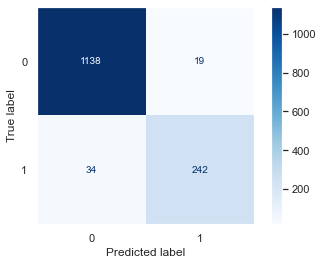

In [96]:
cf=confusion_matrix(y_test, y_pred)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(cf).plot(cmap='Blues')
plt.grid(False)
plt.show();

ROC_AUC: 0.9905803364523442


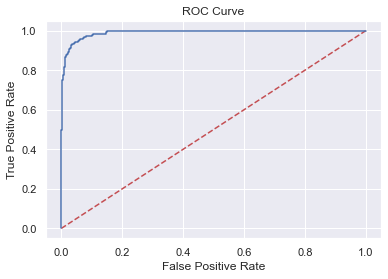

In [98]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lr.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("ROC_AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show();

In [99]:
#Explore feature importance 
coefficients = abs(lr.coef_).transpose()
features = X.columns

In [105]:
feature_importance = {}
for i, coef in enumerate(coefficients):
    feature_importance[features[i]] = coef
    
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['feature_importance'])
feature_importance_df.sort_values('feature_importance', ascending=False).head()

,feature_importance
creation_source_ORG_INVITE,0.071606
days_since_signup,0.062631
email_domain_jourrapide,0.054297
email_domain_gmail,0.053816
opted_in_to_mailing_list,0.053121


### Conclusion

 - To solve this binary classification problem, I trained Logistic regression model to predict whether a user is an adopted user.
 - The five most importance features in this model are:
     - 'creation_source_ORG_INVITE'
     - 'days_since_signup'
     - 'email_domain_jourrapide'
     - 'email_domain_gmail'
     - 'opted_in_to_mailing_list'
     
 - These features pointed out to us that 'creation_source' and 'days_since_signup' could possibly be the two most important factors to determine whether a user would be adopted or not. Surprisingly,  'email_domain_jourrapide' takes such an important role in this model. The model has a very high auc_roc of 99% which gives us an idea the model is performing well in general.